# Human hematopoesis perturbation simulation

## Library imports

In [ ]:
import os
import shutil
import sys

import statsmodels.api as sm

In [1]:
from paths import DATA_DIR, FIG_DIR
from regvelo import REGVELOVI

import networkx as nx
import numpy as np
import pandas as pd
import scipy
from scipy.spatial.distance import cdist
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns
from matplotlib.lines import Line2D

import cellrank as cr
import scanpy as sc
import scvelo as scv
import torch
from scvelo import logging as logg

sys.path.append("../..")

2024-08-30 06:18:31.559037: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-30 06:18:31.604001: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 06:18:32.360609: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/torchvision/image.so: undefined

## General settings

In [2]:
plt.rcParams["svg.fonttype"] = "none"
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

In [3]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "hematopoiesis" / "perturb_repeat_runs", exist_ok=True)
    os.makedirs(FIG_DIR / "hematopoiesis" / "perturbations", exist_ok=True)

SAVE_DATASETS = True
if SAVE_DATASETS:
    os.makedirs(DATA_DIR / "hematopoiesis" / "perturb_repeat_runs", exist_ok=True)

## Function defination

In [4]:
def add_regvelo_outputs_to_adata(adata_raw, vae):
    """TODO."""
    latent_time = vae.get_latent_time(n_samples=30, batch_size=adata_raw.shape[0])
    velocities = vae.get_velocity(n_samples=30, batch_size=adata_raw.shape[0])

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:, vae.module.target_index].copy()

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_regvelo"] = latent_time

    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var["fit_scaling"] = 1.0

    return adata


def add_outputs_to_adata(adata, vae):
    """TODO."""
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr).detach().cpu().numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var["fit_scaling"] = 1.0


def _in_silico_block_simulation(model, adata, gene, regulation_block=True, target_block=True, effects=0, cutoff=0):
    """TODO."""
    reg_vae_perturb = REGVELOVI.load(model, adata)
    perturb_GRN = reg_vae_perturb.module.v_encoder.fc1.weight.detach().clone()

    if regulation_block:
        perturb_GRN[
            (perturb_GRN[:, [i == gene for i in adata.var.index]].abs() > cutoff).cpu().numpy().reshape(-1),
            [i == gene for i in adata.var.index],
        ] = effects
    if target_block:
        perturb_GRN[
            [i == gene for i in adata.var.index],
            (perturb_GRN[[i == gene for i in adata.var.index], :].abs() > 0).cpu().numpy().reshape(-1),
        ] = effects

    reg_vae_perturb.module.v_encoder.fc1.weight.data = perturb_GRN
    adata_target_perturb = add_regvelo_outputs_to_adata(adata, reg_vae_perturb)

    return adata_target_perturb, reg_vae_perturb

In [5]:
def generate_sequence(k, n):
    """TODO."""
    sequence = list(range(1, k + 1))

    # If the length of the sequence is already >= n, trim it to n
    if len(sequence) >= n:
        return sequence[:n]

    # Fill the rest of the sequence with the number k
    sequence.extend([k] * (n - len(sequence)))

    return sequence


def stair_vec(kernel, threshold, terminal_states, cluster_key, all_dict, max_states=12):
    """TODO."""
    pre_value = []
    for num_macro in range(1, max_states):
        try:
            # Append the result to the list
            kernel.compute_macrostates(n_states=num_macro, cluster_key=cluster_key)
            kernel.predict_terminal_states(stability_threshold=threshold)
            pre_terminal = kernel.terminal_states.cat.categories.tolist()
            subset_dict = {key: all_dict[key] for key in pre_terminal}
            pre_terminal_names = list(subset_dict.values())
            pre_terminal_names = list(set(pre_terminal_names))
            pre_value.append(len(set(pre_terminal_names).intersection(terminal_states)))
        except Exception as e:
            # Handle the error, print a message or take any other action
            print(f"Error: {e}")
            # Append 0 to the list as a placeholder for the error
            pre_value.append(pre_value[len(pre_value) - 1])
            raise
        print(pre_value)
    return pre_value


def TSI_score(points, cluster_key, terminal_states, kernel, all_dict, max_states=12):
    """TODO."""
    x_values = range(0, max_states)
    y_values = [0] + generate_sequence(len(terminal_states), max_states - 1)
    area_gs = 0
    for i in range(len(x_values) - 1):
        area_gs += (x_values[i + 1] - x_values[i]) * y_values[i]

    tsi_score = []
    for p in points:
        pre_value = stair_vec(kernel, p, terminal_states, cluster_key, all_dict, max_states)
        x_values = range(0, max_states)
        y_values = [0] + pre_value
        area_velo = 0
        for i in range(len(x_values) - 1):
            area_velo += (x_values[i + 1] - x_values[i]) * y_values[i]
        tsi_score.append(area_velo / area_gs)
    return tsi_score

In [6]:
def prior_GRN(adata, gt_net):
    """TODO."""
    ## filter low co-expressed GRN
    regulator_index = [i in gt_net.columns for i in adata.var.index.values]
    target_index = [i in gt_net.index for i in adata.var.index.values]

    corr_m = 1 - cdist(adata.X.todense().T, adata.X.todense().T, metric="correlation")
    corr_m = torch.tensor(corr_m)
    corr_m = corr_m[target_index,]
    corr_m = corr_m[:, regulator_index]
    corr_m = corr_m.float()

    corr_m[np.isnan(corr_m)] = 0
    corr_m = pd.DataFrame(
        corr_m, index=adata.var.index.values[target_index], columns=adata.var.index.values[regulator_index]
    )
    gt_net = gt_net.loc[corr_m.index, corr_m.columns]
    GRN_final = gt_net * corr_m

    GRN_final[abs(GRN_final) < 0.01] = 0
    GRN_final[GRN_final != 0] = 1
    for i in GRN_final.columns:
        GRN_final.loc[i, i] = 0
    GRN_final = GRN_final.iloc[(GRN_final.sum(1) > 0).tolist(), (GRN_final.sum(0) > 0).tolist()]
    genes = np.unique(GRN_final.index.tolist() + GRN_final.columns.tolist())
    W = torch.zeros((len(genes), len(genes)))
    W = pd.DataFrame(W, index=genes, columns=genes)
    W.loc[GRN_final.columns.tolist(), GRN_final.index.tolist()] = GRN_final.T

    reg_bdata = adata[:, W.index].copy()

    W = W.loc[reg_bdata.var.index.values.tolist(), reg_bdata.var.index.values.tolist()]
    W = torch.tensor(np.array(W))
    reg_bdata.uns["regulators"] = reg_bdata.var.index.values
    reg_bdata.uns["targets"] = reg_bdata.var.index.values
    list(set(reg_bdata.uns["regulators"]).intersection(reg_bdata.uns["targets"]))

    reg_bdata.uns["regulators"] = reg_bdata.var.index.values
    reg_bdata.uns["targets"] = reg_bdata.var.index.values
    reg_bdata.uns["skeleton"] = np.array(W)
    reg_bdata.uns["network"] = np.ones((len(reg_bdata.var.index), len(reg_bdata.var.index)))

    return reg_bdata

In [7]:
def get_significance(pvalue) -> str:
    """TODO."""
    """Assign significance symbol based on p-value."""
    if pvalue < 0.001:
        return "***"
    elif pvalue < 0.01:
        return "**"
    elif pvalue < 0.1:
        return "*"
    else:
        return "n.s."

In [8]:
def threshold_top_k(tensor, k):
    """TODO."""
    # Flatten the tensor
    flattened_tensor = tensor.flatten()

    # Get the indices of the top k positive and negative values
    _, top_k_pos_indices = torch.topk(flattened_tensor, k)
    _, top_k_neg_indices = torch.topk(-flattened_tensor, k)

    # Create a mask for the top k positive and negative values
    mask = torch.zeros_like(flattened_tensor, dtype=torch.float)
    mask[top_k_pos_indices] = 1
    mask[top_k_neg_indices] = 1

    # Reshape the mask to the original tensor shape
    mask = mask.view(tensor.shape)

    return mask


def p_adjust_bh(p):
    """TODO."""
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]


def abundance_test(prob_raw, prob_pert, correction=True):
    """TODO."""
    y = [0] * prob_raw.shape[0] + [1] * prob_pert.shape[0]
    X = pd.concat([prob_raw, prob_pert], 0)

    table = []
    for i in range(prob_raw.shape[1]):
        pred = X.iloc[:, i]
        var = X.iloc[:, [j != i for j in range(prob_raw.shape[1])]]
        # var = sm.add_constant(var)
        est = sm.OLS(pred, var)
        est.fit()
        # pred = pred - est2.predict(var)
        # pred = pred - est2.predict(var)
        # pred = scipy.stats.zscore(pred)
        # pred = np.log(pred * 100 + 0.01)
        table.append(np.expand_dims(np.array(list(scipy.stats.spearmanr(pred, y))), 0))

    table = np.concatenate(table, 0)
    table = pd.DataFrame(table)
    table.index = prob_raw.columns
    table.columns = ["coefficient", "p-value"]
    ## Running FDR addjust
    table.loc[:, "FDR adjusted p-value"] = p_adjust_bh(table.loc[:, "p-value"].tolist())

    return table


def get_list_name(lst):
    """TODO."""
    names = []
    for name, _obj in lst.items():
        names.append(name)
    return names


def has_zero_column_sum(matrix):
    """TODO."""
    # Check if any column sum is zero
    column_sums = matrix.sum(axis=0)
    return np.any(column_sums == 0)


## TODO: if calculation has error, increase the number of macrostates
## if can't fully recover all state, increase the number of macrostates
def TFScanning(model_path, adata, n_states, cluster_label, terminal_states, TF, effect):
    """TODO."""
    reg_vae = REGVELOVI.load(model_path, adata)
    # reg_vae.module = reg_vae.module.cpu()
    adata = add_regvelo_outputs_to_adata(adata, reg_vae)
    raw_GRN = reg_vae.module.v_encoder.fc1.weight.detach().clone()
    perturb_GRN = reg_vae.module.v_encoder.fc1.weight.detach().clone()
    ## curated all targets of specific TF
    raw_GRN.sum(0)
    # TF = adata.var.index[weight != 0].tolist()
    vk = cr.kernels.VelocityKernel(adata)
    vk.compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
    combined_kernel = 0.8 * vk + 0.2 * ck
    g2 = cr.estimators.GPCCA(combined_kernel)
    ## evaluate the fate prob on original space

    g2.compute_macrostates(n_states=n_states, n_cells=30, cluster_key=cluster_label)
    # set a high number of states, and merge some of them and rename
    if terminal_states is None:
        g2.predict_terminal_states()
        terminal_states = g2.terminal_states.cat.categories.tolist()
    g2.set_terminal_states(terminal_states)
    # g2 = g2.rename_terminal_states({"Mono_1": "Mono","DCs_1":"DC"})
    g2.compute_fate_probabilities(solver="direct")
    fate_prob = g2.fate_probabilities
    sampleID = adata.obs.index.tolist()
    fate_name = fate_prob.names.tolist()
    fate_prob = pd.DataFrame(fate_prob, index=sampleID, columns=fate_name)
    fate_prob_original = fate_prob.copy()
    ## create dictionary
    terminal_id = terminal_states.copy()
    terminal_type = terminal_states.copy()
    for i in terminal_states:
        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            terminal_id.append(i + "_" + str(j))
            terminal_type.append(i)
    dict(zip(terminal_id, terminal_type))
    n_states = len(g2.macrostates.cat.categories.tolist())
    coef = []
    pvalue = []
    for tf in TF:
        perturb_GRN = raw_GRN.clone()
        # perturb_GRN[:,[i in tf for i in adata.var.index.tolist()]] = 0
        vec = perturb_GRN[:, [i in tf for i in adata.var.index.tolist()]].clone()
        vec[vec.abs() > 1e-3] = 0
        perturb_GRN[:, [i in tf for i in adata.var.index.tolist()]] = vec
        reg_vae_perturb = REGVELOVI.load(model_path, adata)
        reg_vae_perturb.module.v_encoder.fc1.weight.data = perturb_GRN

        adata_target = add_regvelo_outputs_to_adata(adata, reg_vae_perturb)
        ## perturb the regulations
        vk = cr.kernels.VelocityKernel(adata_target)
        vk.compute_transition_matrix()
        ck = cr.kernels.ConnectivityKernel(adata_target).compute_transition_matrix()
        combined_kernel = 0.8 * vk + 0.2 * ck
        g2 = cr.estimators.GPCCA(combined_kernel)
        ## evaluate the fate prob on original space
        n_states_perturb = n_states
        while True:
            try:
                # Perform some computation in f(a)
                g2.compute_macrostates(n_states=n_states_perturb, n_cells=30, cluster_key=cluster_label)
                # If no error is raised, break the loop and return the result
                # g2.set_terminal_states(
                #    terminal_states
                # )
                break
            except:
                # If an error is raised, increment a and try again, and need to recompute double knock-out reults
                n_states_perturb += 1
                vk = cr.kernels.VelocityKernel(adata)
                vk.compute_transition_matrix()
                ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
                g = cr.estimators.GPCCA(0.8 * vk + 0.2 * ck)
                ## evaluate the fate prob on original space
                g.compute_macrostates(n_states=n_states_perturb, n_cells=30, cluster_key=cluster_label)
                ## set a high number of states, and merge some of them and rename
                if terminal_states is None:
                    g.predict_terminal_states()
                    terminal_states = g.terminal_states.cat.categories.tolist()
                g.set_terminal_states(terminal_states)
                # g2 = g2.rename_terminal_states({"Mono_1": "Mono","DCs_1":"DC"})
                g.compute_fate_probabilities(solver="direct")
                fate_prob = g.fate_probabilities
                sampleID = adata.obs.index.tolist()
                fate_name = fate_prob.names.tolist()
                fate_prob = pd.DataFrame(fate_prob, index=sampleID, columns=fate_name)
                raise

        ## intersection the states
        terminal_states_perturb = g2.macrostates.cat.categories.tolist()
        # terminal_states_perturb = list(set(terminal_states_perturb).intersection(terminal_id))
        terminal_states_perturb = list(set(terminal_states_perturb).intersection(terminal_states))

        g2.set_terminal_states(terminal_states_perturb)
        g2.compute_fate_probabilities(solver="direct")
        fb = g2.fate_probabilities
        sampleID = adata.obs.index.tolist()
        fate_name = fb.names.tolist()
        fb = pd.DataFrame(fb, index=sampleID, columns=fate_name)
        fate_prob2 = pd.DataFrame(columns=terminal_states, index=sampleID)

        for i in terminal_states_perturb:
            # fate_prob2.loc[:,i] = fb.loc[:,[j == i for j in terminal_states_perturb_names]].sum(1).tolist()
            fate_prob2.loc[:, i] = fb.loc[:, i]

        fate_prob2 = fate_prob2.fillna(0)
        arr = np.array(fate_prob2.sum(0))
        arr[arr != 0] = 1
        fate_prob = fate_prob * arr

        [0] * fate_prob.shape[0] + [1] * fate_prob2.shape[0]
        fate_prob2.index = [i + "_perturb" for i in fate_prob2.index]
        test_result = abundance_test(fate_prob, fate_prob2)
        coef.append(test_result.loc[:, "coefficient"])
        pvalue.append(test_result.loc[:, "FDR adjusted p-value"])
        logg.info("Done " + tf)
        fate_prob = fate_prob_original.copy()
    d = {"TF": TF, "coefficient": coef, "pvalue": pvalue}
    # df = pd.DataFrame(data=d)
    return d

## Load dataset

In [9]:
adata_var = sc.read_h5ad(DATA_DIR / "hematopoiesis" / "rgv_adata_re.h5ad")

## Perturbation screening

In [10]:
W = adata_var.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()
TF = adata_var.var_names[adata_var.var["TF"]]

In [11]:
### repeat run the model to get aggregate performance
terminal_states = ["Meg", "Mon", "Bas", "Ery"]
for nrun in range(0, 15):
    print("training model...")
    REGVELOVI.setup_anndata(adata_var, spliced_layer="Ms", unspliced_layer="Mu")
    reg_vae2 = REGVELOVI(adata_var, W=W.T, regulators=TF, lam2=1)

    torch.cuda.empty_cache()
    reg_vae2.train()

    print("save model...")

    model_name = "rgv_model_" + str(nrun)
    coef_name = "coef_" + str(nrun)
    pval_name = "pval_" + str(nrun)

    model = DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / model_name
    coef_save = DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / coef_name
    pval_save = DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / pval_name

    reg_vae2.save(model)

    print("inferring perturbation...")

    while True:
        try:
            perturb_screening = TFScanning(model, adata_var, 6, "cell_type", terminal_states, TF, 0)
            coef = pd.DataFrame(np.array(perturb_screening["coefficient"]))
            coef.index = perturb_screening["TF"]
            coef.columns = get_list_name(perturb_screening["coefficient"][0])

            pval = pd.DataFrame(np.array(perturb_screening["pvalue"]))
            pval.index = perturb_screening["TF"]
            pval.columns = get_list_name(perturb_screening["pvalue"][0])

            rows_with_nan = coef.isna().any(axis=1)
            # Set all values in those rows to NaN
            coef.loc[rows_with_nan, :] = np.nan
            pval.loc[rows_with_nan, :] = np.nan

            coef.to_csv(coef_save)
            pval.to_csv(pval_save)

            break
        except:
            # If an error is raised, increment a and try again, and need to recompute double knock-out reults
            print("perturbation screening has error, retraining model...")
            shutil.rmtree(model)
            REGVELOVI.setup_anndata(adata_var, spliced_layer="Ms", unspliced_layer="Mu")
            reg_vae2 = REGVELOVI(adata_var, W=W.T, regulators=TF, lam2=1)
            reg_vae2.train()
            print("save model...")
            reg_vae2.save(model)
            raise

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


training model...


You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1122/1500:  75%|███████▍  | 1122/1500 [07:42<02:35,  2.42it/s, loss=-186, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -312.116. Signaling Trainer to stop.
save model...
inferring perturbation...
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ARID5B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ATF6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BACH2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done BPTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BRCA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done CEBPZ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CHD2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done CUX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done DEAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ELF2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ERG
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done ETS2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done ETV6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done FOXJ3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done FOXM1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXO3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GFI1B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GTF2I
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done HLTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMBOX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMGA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IKZF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IRF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: 

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done JDP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: 

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done KLF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/1947 [00:00<?, ?cell/s]

Done LMO2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done MECP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2A
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done MEF2C
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFATC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done NFIA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done NFIB
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done NFYC
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NR6A1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NRF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done POU2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done PPARA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RAD21
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done RBPJ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done RREB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SMC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SPI1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done STAT2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done TAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAL1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done TCF4
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done TFCP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFDP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZEB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZFHX3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done ZNF263
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/1947 [00:00<?, ?cell/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Done ZNF274
training model...
Epoch 954/1500:  64%|██████▎   | 954/1500 [06:32<03:44,  2.43it/s, loss=-183, v_num=1]   
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -310.415. Signaling Trainer to stop.
save model...
inferring perturbation...
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ARID5B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ATF6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BACH2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BPTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BRCA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CEBPZ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CHD2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CUX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done DEAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ELF2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ERG
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETS2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETV6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXJ3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXM1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXO3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GFI1B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GTF2I
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HLTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMBOX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMGA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IKZF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IRF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done JDP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done KLF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done LMO2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MECP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2A
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2C
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFATC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIB
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYC
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NR6A1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NRF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done POU2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done PPARA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RAD21
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RBPJ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RREB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SMC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SPI1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAL1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TCF4
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFCP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFDP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZEB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZFHX3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZNF263
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Done ZNF274
training model...
Epoch 1037/1500:  69%|██████▉   | 1037/1500 [07:19<03:16,  2.36it/s, loss=-188, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -311.953. Signaling Trainer to stop.
save model...
inferring perturbation...
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ARID5B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ATF6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BACH2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BPTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BRCA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CEBPZ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CHD2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CUX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done DEAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ELF2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ERG
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETS2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETV6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXJ3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXM1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXO3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GFI1B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GTF2I
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HLTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMBOX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMGA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IKZF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IRF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done JDP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done KLF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done LMO2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MECP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2A
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2C
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFATC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIB
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYC
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NR6A1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NRF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done POU2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done PPARA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RAD21
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RBPJ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RREB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SMC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SPI1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAL1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TCF4
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFCP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFDP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZEB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZFHX3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZNF263
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Done ZNF274
training model...
Epoch 1172/1500:  78%|███████▊  | 1172/1500 [08:03<02:15,  2.43it/s, loss=-195, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -315.550. Signaling Trainer to stop.
save model...
inferring perturbation...
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ARID5B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ATF6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BACH2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BPTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BRCA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CEBPZ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CHD2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CUX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done DEAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ELF2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ERG
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETS2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETV6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXJ3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXM1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXO3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GFI1B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GTF2I
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HLTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMBOX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMGA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IKZF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IRF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done JDP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done KLF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done LMO2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MECP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2A
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2C
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFATC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIB
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYC
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NR6A1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NRF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done POU2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done PPARA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RAD21
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RBPJ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RREB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SMC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SPI1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAL1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TCF4
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFCP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFDP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZEB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZFHX3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZNF263
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Done ZNF274
training model...
Epoch 945/1500:  63%|██████▎   | 945/1500 [06:50<04:00,  2.30it/s, loss=-193, v_num=1]  
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -319.540. Signaling Trainer to stop.
save model...
inferring perturbation...
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ARID5B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ATF6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BACH2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BPTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BRCA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CEBPZ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CHD2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CUX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done DEAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ELF2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ERG
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETS2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETV6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXJ3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXM1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXO3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GFI1B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GTF2I
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HLTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMBOX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMGA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IKZF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IRF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done JDP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done KLF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done LMO2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MECP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2A
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2C
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFATC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIB
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYC
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NR6A1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NRF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done POU2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done PPARA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RAD21
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RBPJ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RREB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SMC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SPI1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAL1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TCF4
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFCP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFDP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZEB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZFHX3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZNF263
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_4/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Done ZNF274
training model...
Epoch 1027/1500:  68%|██████▊   | 1027/1500 [07:05<03:15,  2.41it/s, loss=-179, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -308.114. Signaling Trainer to stop.
save model...
inferring perturbation...
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ARID5B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ATF6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BACH2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BPTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BRCA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CEBPZ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CHD2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CUX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done DEAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ELF2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ERG
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETS2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETV6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXJ3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXM1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXO3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GFI1B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GTF2I
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HLTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMBOX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMGA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IKZF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IRF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done JDP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done KLF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done LMO2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MECP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2A
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2C
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFATC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIB
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYC
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NR6A1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NRF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done POU2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done PPARA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RAD21
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RBPJ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RREB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SMC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SPI1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAL1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TCF4
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFCP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFDP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZEB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZFHX3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZNF263
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_5/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Done ZNF274
training model...
Epoch 1286/1500:  86%|████████▌ | 1286/1500 [09:13<01:32,  2.33it/s, loss=-204, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -324.086. Signaling Trainer to stop.
save model...
inferring perturbation...
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ARID5B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ATF6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BACH2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BPTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BRCA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CEBPZ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CHD2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CUX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done DEAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ELF2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ERG
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETS2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETV6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXJ3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXM1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXO3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GFI1B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GTF2I
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HLTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMBOX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMGA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IKZF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IRF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done JDP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done KLF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done LMO2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MECP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2A
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2C
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFATC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIB
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYC
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NR6A1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NRF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done POU2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done PPARA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RAD21
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RBPJ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RREB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SMC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SPI1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAL1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TCF4
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFCP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFDP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZEB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZFHX3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZNF263
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_6/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Done ZNF274
training model...
Epoch 1012/1500:  67%|██████▋   | 1012/1500 [06:58<03:21,  2.42it/s, loss=-184, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -308.357. Signaling Trainer to stop.
save model...
inferring perturbation...
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ARID5B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ATF6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BACH2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BPTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BRCA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CEBPZ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CHD2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CUX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done DEAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ELF2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ERG
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETS2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETV6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXJ3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXM1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXO3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GFI1B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GTF2I
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HLTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMBOX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMGA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IKZF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IRF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done JDP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done KLF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done LMO2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MECP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2A
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2C
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFATC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIB
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYC
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NR6A1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NRF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done POU2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done PPARA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RAD21
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RBPJ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RREB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SMC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SPI1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAL1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TCF4
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFCP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFDP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZEB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZFHX3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZNF263
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_7/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Done ZNF274
training model...
Epoch 1415/1500:  94%|█████████▍| 1415/1500 [10:20<00:37,  2.28it/s, loss=-204, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -322.304. Signaling Trainer to stop.
save model...
inferring perturbation...
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ARID5B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ATF6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BACH2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BPTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BRCA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CEBPZ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CHD2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CUX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done DEAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ELF2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ERG
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETS2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETV6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXJ3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXM1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXO3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GFI1B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GTF2I
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HLTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMBOX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMGA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IKZF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IRF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done JDP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done KLF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done LMO2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MECP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2A
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2C
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFATC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIB
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYC
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NR6A1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NRF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done POU2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done PPARA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RAD21
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RBPJ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RREB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SMC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SPI1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAL1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TCF4
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFCP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFDP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZEB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZFHX3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZNF263
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_8/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Done ZNF274
training model...
Epoch 1166/1500:  78%|███████▊  | 1166/1500 [08:04<02:18,  2.41it/s, loss=-201, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -324.090. Signaling Trainer to stop.
save model...
inferring perturbation...
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ARID5B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ATF6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BACH2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BPTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BRCA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CEBPZ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CHD2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CUX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done DEAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ELF2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ERG
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETS2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETV6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXJ3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXM1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXO3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GFI1B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GTF2I
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HLTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMBOX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMGA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IKZF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IRF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done JDP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done KLF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done LMO2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MECP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2A
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2C
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFATC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIB
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYC
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NR6A1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NRF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done POU2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done PPARA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RAD21
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RBPJ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RREB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SMC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SPI1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAL1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TCF4
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFCP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFDP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZEB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZFHX3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZNF263
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_9/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Done ZNF274
training model...
Epoch 982/1500:  65%|██████▌   | 982/1500 [06:59<03:41,  2.34it/s, loss=-183, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -310.985. Signaling Trainer to stop.
save model...
inferring perturbation...
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ARID5B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ATF6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BACH2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BPTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BRCA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CEBPZ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CHD2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CUX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done DEAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ELF2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ERG
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETS2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETV6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXJ3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXM1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXO3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GFI1B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GTF2I
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HLTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMBOX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMGA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IKZF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IRF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done JDP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done KLF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done LMO2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MECP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2A
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2C
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFATC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIB
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYC
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NR6A1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NRF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done POU2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done PPARA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RAD21
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RBPJ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RREB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SMC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SPI1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAL1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TCF4
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFCP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFDP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZEB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZFHX3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZNF263
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_10/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Done ZNF274
training model...
Epoch 1169/1500:  78%|███████▊  | 1169/1500 [08:19<02:21,  2.34it/s, loss=-200, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -321.963. Signaling Trainer to stop.
save model...
inferring perturbation...
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ARID5B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ATF6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BACH2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BPTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BRCA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CEBPZ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CHD2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CUX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done DEAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


perturbation screening has error, retraining model...
Epoch 1500/1500: 100%|██████████| 1500/1500 [10:45<00:00,  2.35it/s, loss=-205, v_num=1]

`Trainer.fit` stopped: `max_epochs=1500` reached.


Epoch 1500/1500: 100%|██████████| 1500/1500 [10:45<00:00,  2.32it/s, loss=-205, v_num=1]
save model...
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ARID5B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ATF6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BACH2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BPTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BRCA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CEBPZ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CHD2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CUX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done DEAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ELF2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ERG
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETS2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETV6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXJ3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXM1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXO3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GFI1B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GTF2I
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HLTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMBOX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMGA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IKZF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IRF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done JDP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done KLF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done LMO2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MECP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2A
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2C
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFATC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIB
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYC
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NR6A1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NRF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done POU2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done PPARA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RAD21
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RBPJ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RREB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SMC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SPI1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAL1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TCF4
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFCP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFDP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZEB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZFHX3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZNF263
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_11/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Done ZNF274
training model...
Epoch 1178/1500:  79%|███████▊  | 1178/1500 [08:17<02:15,  2.37it/s, loss=-185, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -314.397. Signaling Trainer to stop.
save model...
inferring perturbation...
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ARID5B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ATF6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BACH2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BPTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BRCA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CEBPZ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CHD2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CUX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done DEAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ELF2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ERG
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETS2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETV6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXJ3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXM1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXO3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GFI1B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GTF2I
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HLTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMBOX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMGA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IKZF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IRF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done JDP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done KLF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done LMO2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MECP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2A
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2C
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFATC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIB
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYC
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NR6A1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NRF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done POU2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done PPARA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RAD21
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RBPJ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RREB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SMC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SPI1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAL1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TCF4
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFCP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFDP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZEB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZFHX3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZNF263
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_12/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Done ZNF274
training model...
Epoch 1346/1500:  90%|████████▉ | 1346/1500 [09:43<01:06,  2.31it/s, loss=-198, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -319.303. Signaling Trainer to stop.
save model...
inferring perturbation...
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ARID5B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ATF6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BACH2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BPTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BRCA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CEBPZ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CHD2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CUX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done DEAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ELF2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ERG
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETS2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETV6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXJ3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXM1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXO3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


perturbation screening has error, retraining model...
Epoch 1298/1500:  87%|████████▋ | 1298/1500 [09:12<01:25,  2.35it/s, loss=-212, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -328.977. Signaling Trainer to stop.
save model...
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ARID5B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ATF6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BACH2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BPTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BRCA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CEBPZ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CHD2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CUX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done DEAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ELF2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ERG
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETS2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETV6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXJ3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXM1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXO3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GFI1B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GTF2I
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HLTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMBOX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMGA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IKZF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IRF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done JDP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done KLF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done LMO2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MECP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2A
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2C
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFATC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIB
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYC
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NR6A1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NRF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done POU2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done PPARA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RAD21
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RBPJ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RREB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SMC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SPI1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAL1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TCF4
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFCP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFDP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZEB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZFHX3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZNF263
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_13/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Done ZNF274
training model...
Epoch 976/1500:  65%|██████▌   | 976/1500 [07:17<03:54,  2.23it/s, loss=-176, v_num=1]  
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -309.365. Signaling Trainer to stop.
save model...
inferring perturbation...
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ARID5B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ATF6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BACH2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BPTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done BRCA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CEBPZ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CHD2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done CUX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done DEAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done E2F2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ELF2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ERG
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETS2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ETV6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXJ3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXM1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXO3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done FOXP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GATA2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GFI1B
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done GTF2I
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HLTF
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMBOX1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done HMGA1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IKZF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done IRF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done JDP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done KLF3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done LMO2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MECP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2A
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done MEF2C
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFATC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFIB
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NFYC
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NR6A1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done NRF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done POU2F1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done PPARA
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RAD21
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RBPJ
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done RREB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SMC3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done SPI1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done STAT6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAF1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TAL1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TCF4
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFCP2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done TFDP1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZEB1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZFHX3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZNF263
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_14/model.pt already downloaded                                                     


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Done ZNF274


## Load the perturbation results

In [12]:
coef = pd.read_csv(DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "coef_0", index_col=0)
coef2 = pd.read_csv(DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "coef_1", index_col=0)
coef3 = pd.read_csv(DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "coef_2", index_col=0)
coef4 = pd.read_csv(DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "coef_3", index_col=0)
coef5 = pd.read_csv(DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "coef_4", index_col=0)

coef6 = pd.read_csv(DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "coef_5", index_col=0)
coef7 = pd.read_csv(DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "coef_6", index_col=0)
coef8 = pd.read_csv(DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "coef_7", index_col=0)
coef9 = pd.read_csv(DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "coef_8", index_col=0)
coef10 = pd.read_csv(DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "coef_9", index_col=0)

coef11 = pd.read_csv(DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "coef_10", index_col=0)
coef12 = pd.read_csv(DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "coef_11", index_col=0)
coef13 = pd.read_csv(DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "coef_12", index_col=0)
coef14 = pd.read_csv(DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "coef_13", index_col=0)
coef15 = pd.read_csv(DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "coef_14", index_col=0)

In [13]:
ery_auc_rgv = []
mon_auc_rgv = []

In [14]:
dfs = [coef, coef2, coef3, coef4, coef5]
coef_all_rep1 = pd.concat(dfs).groupby(level=0).mean()

dfs = [coef6, coef7, coef8, coef9, coef10]
coef_all_rep2 = pd.concat(dfs).groupby(level=0).mean()

dfs = [coef11, coef12, coef13, coef14, coef15]
coef_all_rep3 = pd.concat(dfs).groupby(level=0).mean()

In [15]:
Ery_driver = ["NFIA", "GATA1", "TAL1", "GFI1B", "LMO2"]
driver = Ery_driver
cell_fate = "Ery"

In [16]:
ID = set(driver).intersection(set(coef_all_rep1.index.tolist()))
label = np.zeros(coef_all_rep1.shape[0])
label[[i for i in range(coef_all_rep1.shape[0]) if coef_all_rep1.index.tolist()[i] in list(ID)]] = 1

In [17]:
# Calculate AUROC
score_raw = coef_all_rep1.copy().loc[:, cell_fate]
score_raw[np.isnan(score_raw)] = 0
auroc_ery = roc_auc_score(label, -(score_raw))
ery_auc_rgv.append(auroc_ery)

score_raw = coef_all_rep2.copy().loc[:, cell_fate]
score_raw[np.isnan(score_raw)] = 0
auroc_ery = roc_auc_score(label, -(score_raw))
ery_auc_rgv.append(auroc_ery)

score_raw = coef_all_rep3.copy().loc[:, cell_fate]
score_raw[np.isnan(score_raw)] = 0
auroc_ery = roc_auc_score(label, -(score_raw))
ery_auc_rgv.append(auroc_ery)
ery_auc_rgv

[0.9814814814814815, 0.9148148148148149, 0.9814814814814815]

In [18]:
Mon_driver = ["SPI1", "TCF4", "STAT6", "MEF2C"]
driver = Mon_driver
cell_fate = "Mon"

ID = set(driver).intersection(set(coef_all_rep1.index.tolist()))
label = np.zeros(coef_all_rep1.shape[0])
label[[i for i in range(coef_all_rep1.shape[0]) if coef_all_rep1.index.tolist()[i] in list(ID)]] = 1

# Calculate AUROC
score_raw = coef_all_rep1.copy().loc[:, cell_fate]
score_raw[np.isnan(score_raw)] = 0
auroc_mon = roc_auc_score(label, -(score_raw))
mon_auc_rgv.append(auroc_mon)

score_raw = coef_all_rep2.copy().loc[:, cell_fate]
score_raw[np.isnan(score_raw)] = 0
auroc_mon = roc_auc_score(label, -(score_raw))
mon_auc_rgv.append(auroc_mon)

score_raw = coef_all_rep3.copy().loc[:, cell_fate]
score_raw[np.isnan(score_raw)] = 0
auroc_mon = roc_auc_score(label, -(score_raw))
mon_auc_rgv.append(auroc_mon)
mon_auc_rgv

[0.6772727272727274, 0.6545454545454545, 0.6636363636363637]

## Using CellRank to rank the driver

In [19]:
ery_auc_cr = []
mon_auc_cr = []

In [20]:
model = DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "rgv_model_0"
model = REGVELOVI.load(model, adata_var)
adata_var = add_regvelo_outputs_to_adata(adata_var, model)

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      


In [21]:
terminal_states = ["Meg", "Mon", "Bas", "Ery"]
vk = cr.kernels.VelocityKernel(adata_var)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_var).compute_transition_matrix()
g = cr.estimators.GPCCA(0.8 * vk + 0.2 * ck)
## evaluate the fate prob on original space
g.compute_macrostates(n_states=7, cluster_key="cell_type")
g.set_terminal_states(terminal_states)
g.compute_fate_probabilities()
df = g.compute_lineage_drivers(cluster_key="cell_type")

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


In [22]:
df = df.loc[TF, :].copy()

In [23]:
## Ery driver ranking
Ery_driver = ["NFIA", "GATA1", "TAL1", "GFI1B", "LMO2"]
driver = Ery_driver
cell_fate = "Ery" + "_corr"

ID = set(driver).intersection(set(df.index.tolist()))
label = np.zeros(df.shape[0])
label[[i for i in range(df.shape[0]) if df.index.tolist()[i] in list(ID)]] = 1

# Calculate AUROC
score_raw = df.copy().loc[:, cell_fate]
score_raw[np.isnan(score_raw)] = 0
auroc_ery = roc_auc_score(label, (score_raw))
ery_auc_cr.append(auroc_ery)

## Mon driver ranking
Mon_driver = ["SPI1", "TCF4", "STAT6", "MEF2C"]
driver = Mon_driver
cell_fate = "Mon" + "_corr"

ID = set(driver).intersection(set(df.index.tolist()))
label = np.zeros(df.shape[0])
label[[i for i in range(df.shape[0]) if df.index.tolist()[i] in list(ID)]] = 1

# Calculate AUROC
score_raw = df.copy().loc[:, cell_fate]
score_raw[np.isnan(score_raw)] = 0
auroc_mon = roc_auc_score(label, (score_raw))
mon_auc_cr.append(auroc_mon)

In [24]:
model = DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "rgv_model_1"
model = REGVELOVI.load(model, adata_var)
adata_var = add_regvelo_outputs_to_adata(adata_var, model)

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      


In [25]:
vk = cr.kernels.VelocityKernel(adata_var)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_var).compute_transition_matrix()
g = cr.estimators.GPCCA(0.8 * vk + 0.2 * ck)
## evaluate the fate prob on original space
g.compute_macrostates(n_states=7, cluster_key="cell_type")
g.set_terminal_states(terminal_states)
g.compute_fate_probabilities()
df = g.compute_lineage_drivers(cluster_key="cell_type")

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/4 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


In [26]:
df = df.loc[TF, :].copy()

In [27]:
## Ery driver ranking
Ery_driver = ["NFIA", "GATA1", "TAL1", "GFI1B", "LMO2"]
driver = Ery_driver
cell_fate = "Ery" + "_corr"

ID = set(driver).intersection(set(df.index.tolist()))
label = np.zeros(df.shape[0])
label[[i for i in range(df.shape[0]) if df.index.tolist()[i] in list(ID)]] = 1

# Calculate AUROC
score_raw = df.copy().loc[:, cell_fate]
score_raw[np.isnan(score_raw)] = 0
auroc_ery = roc_auc_score(label, (score_raw))
ery_auc_cr.append(auroc_ery)

## Mon driver ranking
Mon_driver = ["SPI1", "TCF4", "STAT6", "MEF2C"]
driver = Mon_driver
cell_fate = "Mon" + "_corr"

ID = set(driver).intersection(set(df.index.tolist()))
label = np.zeros(df.shape[0])
label[[i for i in range(df.shape[0]) if df.index.tolist()[i] in list(ID)]] = 1

# Calculate AUROC
score_raw = df.copy().loc[:, cell_fate]
score_raw[np.isnan(score_raw)] = 0
auroc_mon = roc_auc_score(label, (score_raw))
mon_auc_cr.append(auroc_mon)

In [28]:
model = DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "rgv_model_2"
model = REGVELOVI.load(model, adata_var)
adata_var = add_regvelo_outputs_to_adata(adata_var, model)

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded                                                      


In [29]:
vk = cr.kernels.VelocityKernel(adata_var)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_var).compute_transition_matrix()
g = cr.estimators.GPCCA(0.8 * vk + 0.2 * ck)
## evaluate the fate prob on original space
g.compute_macrostates(n_states=7, cluster_key="cell_type")
g.set_terminal_states(terminal_states)
g.compute_fate_probabilities()
df = g.compute_lineage_drivers(cluster_key="cell_type")

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

In [30]:
df = df.loc[TF, :].copy()

In [31]:
## Ery driver ranking
Ery_driver = ["NFIA", "GATA1", "TAL1", "GFI1B", "LMO2"]
driver = Ery_driver
cell_fate = "Ery" + "_corr"

ID = set(driver).intersection(set(df.index.tolist()))
label = np.zeros(df.shape[0])
label[[i for i in range(df.shape[0]) if df.index.tolist()[i] in list(ID)]] = 1

# Calculate AUROC
score_raw = df.copy().loc[:, cell_fate]
score_raw[np.isnan(score_raw)] = 0
auroc_ery = roc_auc_score(label, (score_raw))
ery_auc_cr.append(auroc_ery)

## Mon driver ranking
Mon_driver = ["SPI1", "TCF4", "STAT6", "MEF2C"]
driver = Mon_driver
cell_fate = "Mon" + "_corr"

ID = set(driver).intersection(set(df.index.tolist()))
label = np.zeros(df.shape[0])
label[[i for i in range(df.shape[0]) if df.index.tolist()[i] in list(ID)]] = 1

# Calculate AUROC
score_raw = df.copy().loc[:, cell_fate]
score_raw[np.isnan(score_raw)] = 0
auroc_mon = roc_auc_score(label, (score_raw))
mon_auc_cr.append(auroc_mon)

## Plot driver ranking results

In [32]:
data = pd.DataFrame(
    {
        "AUROC": ery_auc_rgv + mon_auc_rgv + ery_auc_cr + mon_auc_cr + [0.88148, 0.612626],
        "Terminal state": ["Ery"] * 3 + ["Mon"] * 3 + ["Ery"] * 3 + ["Mon"] * 3 + ["Ery", "Mon"],
        "Method": ["RegVelo(PS)"] * 6 + ["RegVelo(CR)"] * 6 + ["dynamo(LAP)"] * 2,
    }
)

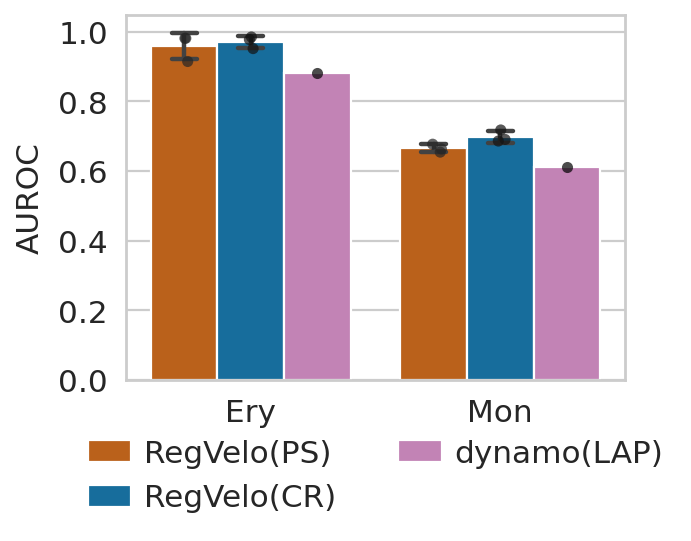

In [33]:
with mplscience.style_context():
    pal = {"RegVelo(PS)": "#d55e00", "RegVelo(CR)": "#0173b2", "dynamo(LAP)": "#cc78bc"}
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(4, 3))

    sns.barplot(x="Terminal state", y="AUROC", hue="Method", data=data, ci="sd", capsize=0.1, errwidth=2, palette=pal)
    sns.stripplot(
        x="Terminal state", y="AUROC", hue="Method", data=data, dodge=True, jitter=True, color="black", alpha=0.7
    )

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[3:6], labels[3:6], bbox_to_anchor=(0.5, -0.44), loc="lower center", ncol=2, fontsize=14)

    plt.ylabel("AUROC", fontsize=14)
    plt.xlabel("", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if SAVE_FIGURES:
        plt.savefig(
            FIG_DIR / "hematopoiesis" / "perturbations" / "driver_ranking.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )

## Visualize PU.1 and GATA1 perturbation

In [34]:
model = DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "rgv_model_3"
model = REGVELOVI.load(model, adata_var)
adata_var = add_regvelo_outputs_to_adata(adata_var, model)

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

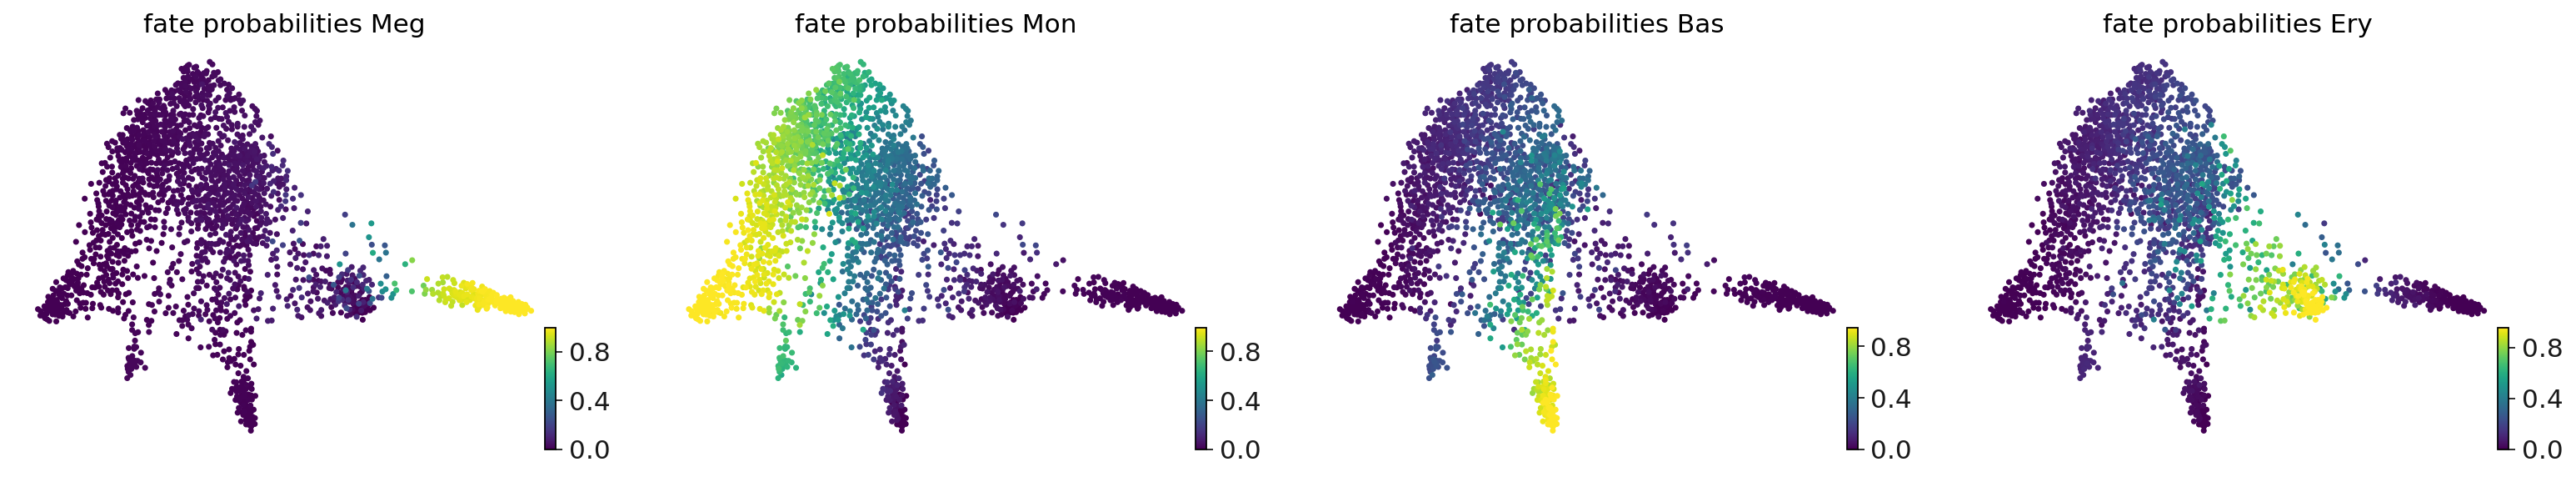

In [35]:
terminal_states = ["Meg", "Mon", "Bas", "Ery"]
vk = cr.kernels.VelocityKernel(adata_var)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_var).compute_transition_matrix()
g = cr.estimators.GPCCA(0.8 * vk + 0.2 * ck)
## evaluate the fate prob on original space
g.compute_macrostates(n_states=6, cluster_key="cell_type")
g.set_terminal_states(terminal_states)
g.compute_fate_probabilities()
g.plot_fate_probabilities(same_plot=False, basis="draw_graph_fa")

In [36]:
## Knockout GATA1 simulation
model = DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "rgv_model_3"
adata_target_perturb, reg_vae_perturb = _in_silico_block_simulation(
    model, adata_var, "GATA1", target_block=False, effects=0
)

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


In [37]:
vk = cr.kernels.VelocityKernel(adata_target_perturb)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_target_perturb).compute_transition_matrix()
g = cr.estimators.GPCCA(0.8 * vk + 0.2 * ck)
## evaluate the fate prob on original space
g.compute_macrostates(n_states=6, cluster_key="cell_type")
g.set_terminal_states(terminal_states)
g.compute_fate_probabilities()

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


In [38]:
cond1_df = pd.DataFrame(
    adata_target_perturb.obsm["lineages_fwd"], columns=adata_target_perturb.obsm["lineages_fwd"].names.tolist()
)
cond2_df = pd.DataFrame(adata_var.obsm["lineages_fwd"], columns=adata_var.obsm["lineages_fwd"].names.tolist())

In [39]:
## plot
cell_fate = []
for i in range(cond1_df.shape[0]):
    if cond2_df.iloc[i, 1] > 0.8 and np.abs(cond1_df.iloc[i, 1] - cond2_df.iloc[i, 1]) > 0:
        cell_fate.append(cond1_df.iloc[i, 1] - cond2_df.iloc[i, 1])
    elif cond2_df.iloc[i, 3] > 0.5 and np.abs(cond1_df.iloc[i, 3] - cond2_df.iloc[i, 3]) > 0:
        cell_fate.append(cond1_df.iloc[i, 3] - cond2_df.iloc[i, 3])
    else:
        cell_fate.append(np.nan)

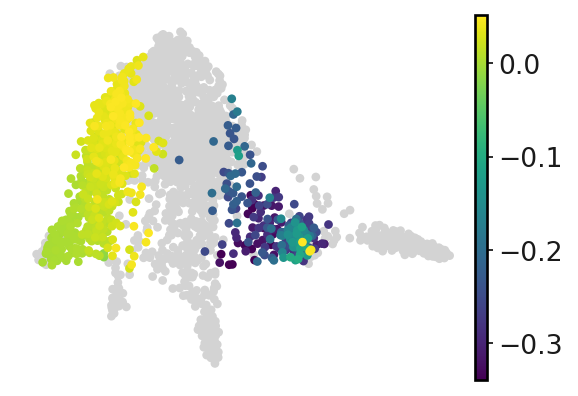

In [40]:
adata_var.obs["GATA1_perturb_effects"] = cell_fate

with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4, 3))
    sc.pl.embedding(
        adata_var,
        basis="draw_graph_fa",
        color="GATA1_perturb_effects",
        frameon=False,
        vmin="p1",
        vmax="p99",
        title="",
        ax=ax,
    )

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "hematopoiesis" / "perturbations" / "GATA1_perturbation.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )

In [41]:
## Knockout GATA1 simulation
model = DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "rgv_model_3"
adata_target_perturb, reg_vae_perturb = _in_silico_block_simulation(
    model, adata_var, "SPI1", target_block=False, effects=0
)

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_3/model.pt already downloaded                                                      


In [42]:
vk = cr.kernels.VelocityKernel(adata_target_perturb)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_target_perturb).compute_transition_matrix()
g = cr.estimators.GPCCA(0.8 * vk + 0.2 * ck)
## evaluate the fate prob on original space
g.compute_macrostates(n_states=6, cluster_key="cell_type")
g.set_terminal_states(terminal_states)
g.compute_fate_probabilities()

  0%|          | 0/1947 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


In [43]:
cond1_df = pd.DataFrame(
    adata_target_perturb.obsm["lineages_fwd"], columns=adata_target_perturb.obsm["lineages_fwd"].names.tolist()
)
cond2_df = pd.DataFrame(adata_var.obsm["lineages_fwd"], columns=adata_var.obsm["lineages_fwd"].names.tolist())

In [44]:
## plot
cell_fate = []
for i in range(cond1_df.shape[0]):
    if cond2_df.iloc[i, 1] > 0.8 and np.abs(cond1_df.iloc[i, 1] - cond2_df.iloc[i, 1]) > 0:
        cell_fate.append(cond1_df.iloc[i, 1] - cond2_df.iloc[i, 1])
    elif cond2_df.iloc[i, 3] > 0.5 and np.abs(cond1_df.iloc[i, 3] - cond2_df.iloc[i, 3]) > 0:
        cell_fate.append(cond1_df.iloc[i, 3] - cond2_df.iloc[i, 3])
    else:
        cell_fate.append(np.nan)

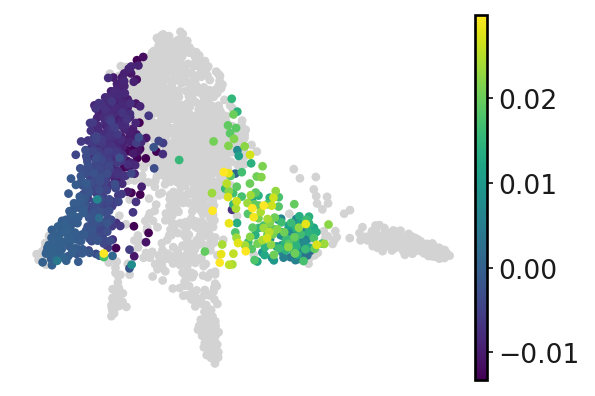

In [45]:
adata_var.obs["SPI1_perturb_effects"] = cell_fate

with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4, 3))
    sc.pl.embedding(
        adata_var,
        basis="draw_graph_fa",
        color="SPI1_perturb_effects",
        frameon=False,
        vmin="p1",
        vmax="p99",
        title="",
        ax=ax,
    )

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "hematopoiesis" / "perturbations" / "SPI1_perturbation.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )

## Zoom-in the regulatory motif

In [46]:
model = DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "rgv_model_0"
reg_vae = REGVELOVI.load(model, adata_var)
grn1 = reg_vae.module.v_encoder.fc1.weight

model = DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "rgv_model_1"
reg_vae = REGVELOVI.load(model, adata_var)
grn2 = reg_vae.module.v_encoder.fc1.weight

model = DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "rgv_model_2"
reg_vae = REGVELOVI.load(model, adata_var)
grn3 = reg_vae.module.v_encoder.fc1.weight

model = DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "rgv_model_3"
reg_vae = REGVELOVI.load(model, adata_var)
grn4 = reg_vae.module.v_encoder.fc1.weight

model = DATA_DIR / "hematopoiesis" / "perturb_repeat_runs" / "rgv_model_4"
reg_vae = REGVELOVI.load(model, adata_var)
grn5 = reg_vae.module.v_encoder.fc1.weight

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/hematopoiesis/perturb
         _repeat_runs/rgv_model_2/model.pt already downloaded           

In [47]:
GRN = torch.stack((grn1, grn2, grn3, grn4, grn5))
GRN = torch.mean(GRN, dim=0)

In [48]:
GRN[[i == "GATA1" for i in adata_var.var.index], [i == "SPI1" for i in adata_var.var.index]]

tensor([-0.1120], device='cuda:0', grad_fn=<IndexBackward0>)

In [49]:
GRN[[i == "SPI1" for i in adata_var.var.index], [i == "GATA1" for i in adata_var.var.index]]

tensor([-1.4585], device='cuda:0', grad_fn=<IndexBackward0>)

## plot toggle switch

In [50]:
GRN = GRN.detach().cpu().numpy()

In [51]:
GRN_visualize = [
    ["SPI1", "GATA1", GRN[[i == "GATA1" for i in adata_var.var.index], [i == "SPI1" for i in adata_var.var.index]][0]],
    ["GATA1", "SPI1", GRN[[i == "SPI1" for i in adata_var.var.index], [i == "GATA1" for i in adata_var.var.index]][0]],
]
GRN_visualize = pd.DataFrame(GRN_visualize)

In [52]:
GRN_visualize.columns = ["from", "to", "weight"]

In [53]:
GRN_visualize["weight"] = np.sign(GRN_visualize["weight"])

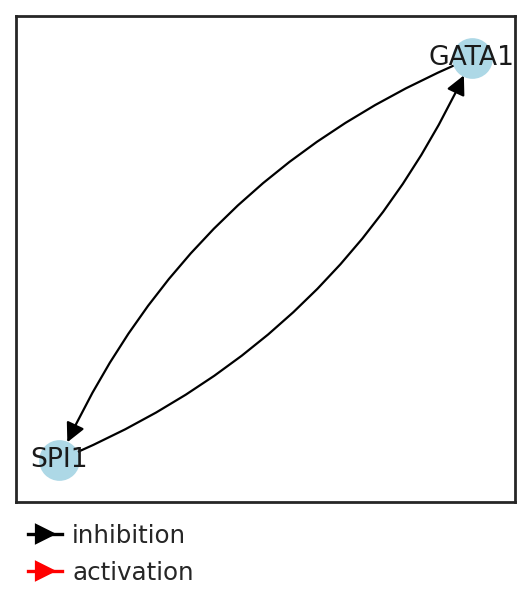

In [54]:
legend_elements = [
    Line2D([0], [0], marker=">", color="black", label="inhibition", markerfacecolor="black", markersize=8),
    Line2D([0], [0], marker=">", color="red", label="activation", markerfacecolor="red", markersize=8),
]

with mplscience.style_context():
    sns.set(style="white")
    fig, ax = plt.subplots(figsize=(4, 4))

    cont = GRN_visualize
    contLines = []
    genes = set()
    G = nx.MultiDiGraph()
    pEdges = []
    nEdges = []
    for line in range(cont.shape[0]):
        tmp = cont.iloc[line, :]
        genes.add(tmp[0])
        genes.add(tmp[1])
        contLines.append(tmp.tolist())
    genes = list(genes)
    selfActGenes = set()
    selfInhGenes = set()
    G.add_nodes_from(genes)
    for edge in contLines:
        row = genes.index(edge[0])
        col = genes.index(edge[1])
        if edge[2] == 1:
            pEdges.append((edge[0], edge[1]))
            if row == col:
                selfActGenes.add(edge[0])
        elif edge[2] == -1:
            nEdges.append((edge[0], edge[1]))
            if row == col:
                selfInhGenes.add(edge[0])
        else:
            print("Unsupported regulatory relationship.")
    selfActGenes = list(selfActGenes)
    selfInhGenes = list(selfInhGenes)
    # show grn by network visualization
    G.add_edges_from(pEdges)
    G.add_edges_from(nEdges)
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_color="lightblue")  # initial colors for all nodes
    nx.draw_networkx_nodes(G, pos, nodelist=selfActGenes, node_color="red")  # red colors indicating activation
    nx.draw_networkx_nodes(G, pos, nodelist=selfInhGenes, node_color="black")  # black colors indicating inhibition
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, edgelist=pEdges, edge_color="red", connectionstyle="arc3,rad=0.2", arrowsize=18)
    nx.draw_networkx_edges(
        G, pos, edgelist=nEdges, edge_color="black", arrows=True, connectionstyle="arc3,rad=0.2", arrowsize=18
    )
    plt.legend(handles=legend_elements, bbox_to_anchor=(0.4, 0))

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "hematopoiesis" / "perturbations" / "SPI1-GATA1-network.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )